<a href="https://colab.research.google.com/github/zurkin1/Machine-Learning/blob/master/Ex4_Deep_Learning_for_Machine_Perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><b>Deep Learning for Machine Perception</b></center></h1>
<h3><center>Exercise 4</center></h3>

Your Names:  
<font color='red'>
FirstName1 LastName1, 123456789  
FirstName2 LastName2, 987654321  
</font>


____________

In this exercise we will:
1. Implement the Neural-Style Transfer algorithm and understand how it works.
2. Style a given image according to a given style.
3. Understand the importance of interpretbility.
4. Implement the Grad-CAM algorithm.

**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Make sure you don't leave empty cells or empty answers.
- You should not change the code that we have provided to you.
- When you finish the assignment, download the *notebook* and submit it to the [**"submit"**](https://submit.cs.biu.ac.il/cgi-bin/welcome.cgi) system. 
To Download the notebook go to **"File"** -> **"Download .ipynb"**.  
- For questions regarding the assignment send a mail to: ‫biu.cs.896874@gmail.com‬  

### **1. Setup**
Before running code on Colab:
- Go to "Runtime" -> "Change runtime type", and make sure to choose "GPU" for Hardware accelerator.
- Check your Python version at the command line by running "!python --version". It should be Python 3.6 by default.

In [ ]:
# check python version
!python --version

### **2. Neural Style Transfer**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import transforms, models

In this exercise, we are going to implement the Neural Style Transfer algorithm which is based on the paper ["A Neural Algorithm of Artistic Style"](https://arxiv.org/abs/1508.06576) by Leon A. Gatys et al.

The Neural Style Transfer algorithm allows us to take an image and reproduce it with a new artistic style.

In other words, it separates the **content** and **style** of images and creates new images by mixing the style of one given image and the content of another.

Examples:

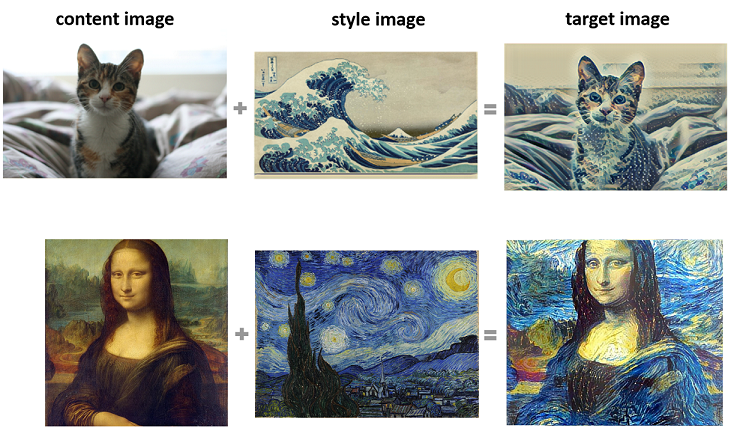

##### **2.1 Preparations**

Before starting implementing the algorithm, we will first define two utility  functions:  
1. Transferring images to pytorch tensors.  
2. Transfering tensors to images.

Let's first download two images: a content image and a style image.

In [ ]:
# download content image
!wget https://i.postimg.cc/Bn3CCpvy/f-Fn-Yv6g-LBY7a-AJj2u-Yp-Q6i.jpg -O content.jpg

# download style image
!wget https://i.postimg.cc/kGDHqcSw/style.png -O style.jpg

In [ ]:
content_image_path = "./content.jpg"
style_image_path = "./style.jpg"

We would like to visualize the two images. We can use PIL to load images and matplotlib to plot them.

In [ ]:
def image_path_to_numpy(image_path):
  # load image into a numpy array from the given path
  return Image.open(image_path).convert('RGB') 

In [ ]:
content_numpy = image_path_to_numpy(content_image_path)
style_numpy = image_path_to_numpy(style_image_path)

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(content_numpy)
ax1.set_title("Content Image")
ax2.imshow(style_numpy)
ax2.set_title("Style Image")

We can now implement the function ```image_to_tensor``` below which takes a numpy array (an image) and converts it to a tensor. It also normalizes the image: Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, it normalizes each channel of the input image. i.e., output[channel] = (input[channel] - mean[channel]) / std[channel].

In [ ]:
def image_to_tensor(image_numpy, max_size=400, shape=None):
  
  # crop image if image is too big
  if max(image_numpy.size) > max_size:
    size = max_size
  else:
    size = max(image_numpy.size)
	
  size = (size, int(1.5*size))
  # if shape is given use it
  if shape is not None:
    size = shape
  
  # resize and normalize the image
  in_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
  image = in_transform(image_numpy)[:3, :, :].unsqueeze(0)
  
  return image

In [ ]:
content_tensor = image_to_tensor(content_numpy)
print("Content Shape:", content_tensor.shape)

style_tensor = image_to_tensor(style_numpy)
print("Style Shape:", style_tensor.shape)

Notice that the two images were resized and they have now the same width and height.

Next, let's implement the reverse function ```tensor_to_numpy```. It will help us later display generated images.

In [ ]:
def tensor_to_numpy(image_tensor):
  image = image_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

##### **2.2 Model setup**

In the [paper](https://arxiv.org/abs/1508.06576), style transfer uses **the features\*** of a pretrained [VGG-19 network](https://arxiv.org/abs/1409.1556) (19 - #layers within the network). VGG is a simple CNN network that is comprised of a series of convolutional, pooling layers and a few fully connected layers (you can see its architecture below).  

\* Features are the outputs of inner layers of a neural network. They are obtained by performing a forward pass through the model given an input image.

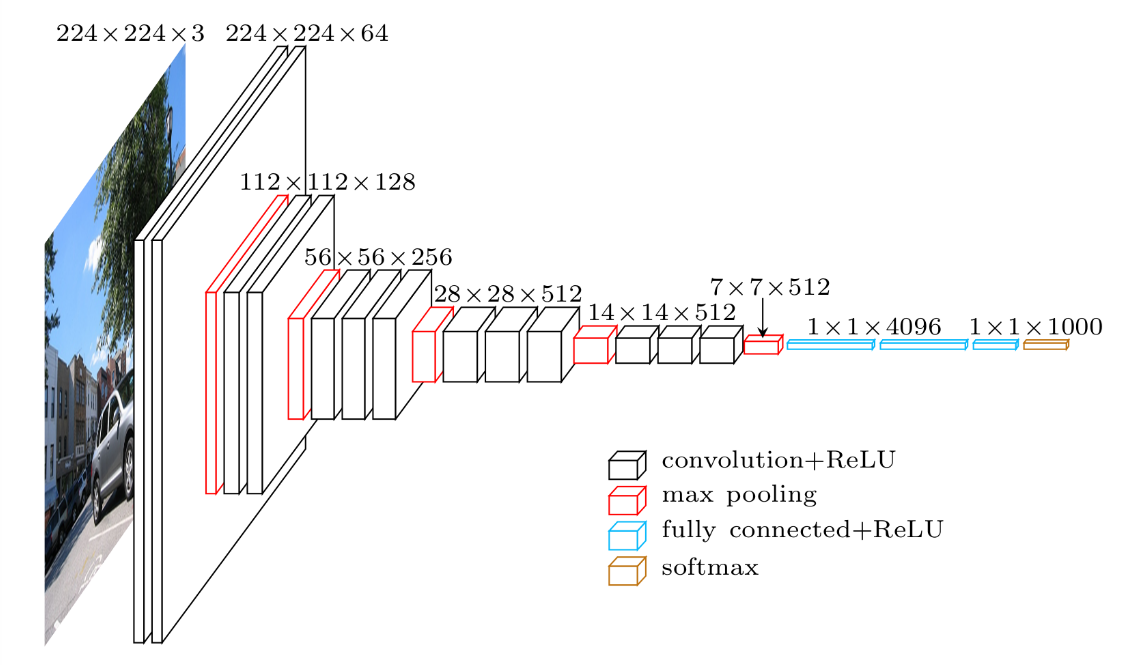

How can features help us?  

From the paper:    
*\"When Convolutional Neural Networks are trained on object recognition, they develop a representation of the image that makes object information increasingly explicit along the processing hierarchy. Therefore, along the processing hierarchy of the network, the input image is transformed into representations that increasingly care about the actual content of the image compared to its detailed pixel values.\"*  

Meaning, the features of certain layers within a CNN capture both **style** and **content** of the images fed into the model.

**Important:**  
Note that here we don't want to learn the weights of the VGG! We would like to learn how to **change an input image** to become with the content of a 'content image' but with the style of a 'style image'. Thus, the gradient descent process is different from how neural networks are usually trained.  
We use a pretrained VGG-19, keep all layers fixed (the weights won't change during training) and treat the input image's pixel values as parameters! Our gradients will then be backpropagated to the inputs, thus changing the input (the image).

We can start by downloading a pretrained VGG-19 using ```torchvision```.  

In [ ]:
vgg = models.vgg19(pretrained=True)

Print all modules of the vgg model:

In [ ]:
# print the modules of the vgg model
######################
### YOUR CODE HERE ###
######################

You can see that the VGG19 is split into two portions:

* ```vgg19.features```, which are all the convolutional and pooling layers
* ```vgg19.classifier```, which are the three fully connected at the end.  

You can also see that each layer has a name (an index). For example: The first conv2d layer has the name "0". The indices will help us later.

As we said before, we are going to freeze all layers and use the features portion only. You can read about freezing network layers here: [Pytorch Autograd Mechanics](https://pytorch.org/docs/master/notes/autograd.html).

Implement the function ```freeze_network``` below.

In [ ]:
def freeze_network(net):
  '''
  The function freezes all layers of a pytorch network (net).
  '''
  ######################
  ### YOUR CODE HERE ###
  ######################
  pass

In [ ]:
# freeze all VGG parameters
freeze_network(vgg)

In the [paper](https://arxiv.org/abs/1508.06576), the authors propose to replace all ```max pooling layers``` with ```average pooling layers``` for better-looking results.
Implement the function that does that.

In [ ]:
def replace_max_pooling(net):
  '''
  The function replaces max pooling layers with average pooling layers with 
  the following properties: kernel_size=2, stride=2, padding=0.
  '''
  ######################
  ### YOUR CODE HERE ###
  ######################
  pass

In [ ]:
# replace max pooling with avg pooling
replace_max_pooling(vgg)

Print the vgg modules again and make sure that the replacement has indeed taken place. 

In [ ]:
######################
### YOUR CODE HERE ###
######################

We can now transfer all to the gpu.

In [ ]:
# move the model to the GPU
vgg = vgg.to("cuda").eval()
# move images to gpu
content_tensor = content_tensor.to("cuda")
style_tensor = style_tensor.to("cuda")

##### **2.3 Content Loss**

We start with implementing the content loss.  
The content loss will help us preserve the original content of the content image in the generated image.  
It is simply the mean squared difference between the target and content features.

More formally: Given a content image **C**, a target (generated) image **G** and a layer **L** the *Content Loss* is defined as

$$Loss_{content}(C,G,L) = \frac{1}{D_LH_LW_L}\sum_{ij}{(a[L](C)_{ij} - a[L](G)_{ij})^2}$$

where $a[L](C)_{ij}$ is the is the activation of the $i$-th filter at position $j$ in layer $L$ when passing an image $C$. Same for $a[L](G)_{ij}$.  
$D_L$ - Depth/number channels of the output of layer $L$  
$H_L$ - Height of the output of layer $L$  
$W_L$ - Width of the output of layer $L$

Before implementing the loss, let's implement a function that extracts features given a model and an image.

The paper suggests extracting features from several convolutional layers.  
Layer 21 will be used for the Content Loss and Layers 0, 5, 10, 19, 28 will be used for the Style Loss (which we will implement in the next section).

In [ ]:
def get_features(net, image_tensor):
    ''' 
    The function runs a forward pass given an image and extracts the features for 
    several conv layers. It returns a dictionary where the keys are the
    layers name and the values are the features.
    '''
    layers_idx = ['0','5','10','19','21','28']
    features = {}
    ######################
    ### YOUR CODE HERE ###
    ######################
    # ...
    ######################
    return features

Now implement the Content Loss function below. Remember that you only need to use Layer 21 here. Note that you must use torch functions (like ```torch.mean``` or ```F.mse_loss```) so we can later do backpropagation and pass gradients.

In [ ]:
def calculate_content_loss(target_features, content_features, layer_id='21'):
  ######################
  ### YOUR CODE HERE ###
  ######################
  # content_loss = ...
  return content_loss

You can check your implementation by calculating the loss when comparing the content image and the style image.

In [ ]:
# extract features for content image
content_features = get_features(vgg, content_tensor)
# extract features for style image
style_features = get_features(vgg, style_tensor)

In [ ]:
calculate_content_loss(content_features, style_features)

If you implemented everything correctly, the loss should be ```1.2261```.

##### **2.3 Style Loss**

Let's implement the style loss.  
Unlike the content loss where only the difference between features is sufficient to capture the content, the style loss needs a way to compare styles.
As it turns out, style representations can be obtained by measuring the correlation between different feature map responses of a given layer.  
In other words, the style loss considers feature representation of many convolution layers from shallow to deeper layers of the model and for each layer it calculates the correlation between channels. We can then compare this correlation between the target image and the style image.

The correlation can be calculated using the [Gram Matrix](https://en.wikipedia.org/wiki/Gramian_matrix).
The Gram matrix is an approximation of the covariance matrix: It tells us how every channel's values (i.e. that filter's activations) correlate with every other channel's values. If we have $c$ channels, matrix $GM$ will be of shape $[c, c]$ to capture these correlations between all channel pairs.

More formally:  
Given an activation $a[L](I)$ (activation of layer $L$ given input image $I$) of shape $[c, h, w]$, we can flatten the height and width dimensions so there is just 1 dimension $m = h \times w$ such that the new shape of $a[L](I)$ is $[c, m]$.  
The Gram Matrix for layer $L$ has shape $[c, c]$ where each element is given by the equation:

$$GM^{L}_{ij}  = \sum_k a[L](I)_{ik} a[L](I)_{jk}$$

[note that $i$,$j$ are filters and $k$ is a pixel (position in those filters)].



Implement the function below which takes a tensor and calculates its gram matrix. Note that you must use torch functions (like ```torch.mm```) so we can later do backpropagation and pass gradients.

In [ ]:
def calculate_gram_matrix(tensor):
    ''' 
    The function calculates the Gram Matrix of a given tensor with shape (batch_size, depth, height, width)
    '''
    ######################
    ### YOUR CODE HERE ###
    ######################
    # gram = ...
    ######################
    return gram 

You can check your implementation with the dummy example below.

In [ ]:
dummy_tensor = torch.tensor([[[[1,2,3],[4,5,6],[7,8,9]],
                              [[10,20,30],[40,50,60],[70,80,90]]]])
calculate_gram_matrix(dummy_tensor)

If your implemetaion is correct the result should be   ```
tensor([[  285,  2850],
        [ 2850, 28500]])
```

Now implement the Style Loss:  
Given style image **S** and a target (generated) image **G** the *Style Loss* is defined as

$$Loss_{style}(S,G) = \sum_{i=0}^{L}{w_l * Loss_{GM}(S,G,l)}$$

where $w_l$ is the weight we give for a layer $l$ and $Loss_{GM}(S,G,l)$ is the loss for that layer:  

$$Loss_{GM}(S,G,l) = \frac{1}{D_l^3H_lW_l}\sum_{ij}(GM[l](S)_{ij} - GM[l](G)_{ij})^2$$

$ij$ - $i$-th filter at position $j$  
$GM[l](S)$ - Gram matrix of the style image of layer $l$  
$GM[l](G)$ - Gram matrix of the target image of layer $l$  
$D_l$ - Depth/number channels of the output of layer $l$  
$H_l$ - Height of the output of layer $l$  
$W_l$ - Width of the output of layer $l$



As mentioned before, for the style loss we are going to use layers 0, 5, 10 ,19 and 28.  
We give different weights for layers such that deeper layers have a smaller impact on the loss:

In [ ]:
layers_weights = {'0': 0.75,
                 '5': 0.5,
                 '10': 0.2,
                 '19': 0.2,
                 '28': 0.2}

In [ ]:
def calculate_style_loss(target_features, style_features, layers_weights):
    ''' 
    The function calculates the style loss given the target features and style features
    using the weights for all layers (layers_weights).
    '''
    style_loss = 0
    ######################
    ### YOUR CODE HERE ###
    ######################
    # ...
    ######################
    return style_loss

In [ ]:
calculate_style_loss(content_features, style_features, layers_weights)

If you implemented everything correctly, the loss should be 30.8579.

##### **2.4 Total Loss & Gradient Descent**

Now that we have both content and style loss we can add them up and perform gradient descent to change the generated image such that it decreases its loss after each iteration.


The total loss would be:  

$$Loss_{total} = \alpha Loss_{content}(C,G) + \beta Loss_{style}(S,G)$$

where alpha and beta are hyperparameters that weights each loss to control the tradeoff between content and style.

Implement the function ```style_transfer``` below.   
Hyperparameters:
- Use Adam optimizer with $lr=0.01$
- Set $\alpha=1e4$ and $\beta=1e2$
- 1000 iterations should be enough

In [ ]:
def style_transfer(vgg_model, content_tensor, style_tensor,
                   alpha, beta, n_iterations, learning_rate):
  '''
  The function runs the style transfer algorithm using a pretrained and freezed vgg_model,
  a content image tensor and style image tensor. It weights the content loss with alpha
  and style loss with beta. It runs for n_iterations.
  '''
  # creating a random image and set requires_grad to True
  target_image = torch.randn_like(content_tensor).requires_grad_(True).to("cuda")
  # extract content features
  content_features = get_features(vgg_model, content_tensor)
  # extract features for style image
  style_features = get_features(vgg_model, style_tensor)

  ######################
  ### YOUR CODE HERE ###
  ######################
  # create optimizer to optimize the target image 
  # optimizer = ...
  for i in range(n_iterations):
    # ...
    # content_loss = ...
    # style_loss = ...
    # total_loss = ...

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, Content Loss: {content_loss.item():.2f}, Style  Loss {style_loss.item():.2f}")
  ######################
  
  return target_image

In [ ]:
final_image = style_transfer(vgg, content_tensor, style_tensor,
                             alpha=1e4, beta=1e2, n_iterations=1000, learning_rate=0.01)

Let's look at the final result:

In [ ]:
plt.imshow(tensor_to_numpy(final_image))

**Your turn:** Download your own content and style images and run the style-transfer algorithm. Adjust the hyper-parameters to get awesome looking results.

In [ ]:
######################
### YOUR CODE HERE ###
######################

### **3. Interpretbility and Grad-CAM**

In this section, we are going to implement the Grad-Cam algorithm. The algorithm was originally proposed by Selvaraju el al [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391).
 
Grad-Cam is a powerful technique to understand neural network decisions. Specifically, what particular parts of the image influenced the whole model’s decision for a specifically assigned label.

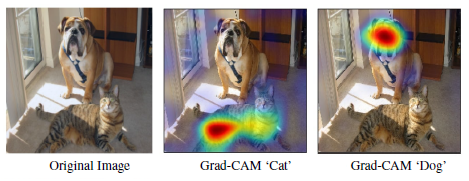

From the image above we can tell that the network looks at the head of the dog to identify it as a dog, while it looks at the body of the cat (and its tail) to recognize it as a cat.


The idea of Grad-CAM is simple:  
Pass an image through a pretrained network and extract the activation maps (features) from the last convolutional layer. Those features can be interpreted as some encoded features that ended up activated in the final activation map which made the model as a whole to choose a specific class. Then, find the most-probable class (most dominant logit) and from that class, calculate the gradients (which tells us what is the influence of each activation on the output). By weighting each activation with its gradient we can tell which ones played the most significant role in the decision of the class.

The algorithm has three steps:

##### **3.1 Gradients of Last Conv Layer**

The first step is to pass the input image through a pretrained network, extract features from the last layer and calculate gradients of that layer.  

We are going to use a pretrained VGG-19 network. The network architecture as you saw in the previous section is:

```
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (24): ReLU(inplace=True)
    (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (26): ReLU(inplace=True)
    (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): ReLU(inplace=True)
    (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (33): ReLU(inplace=True)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): ReLU(inplace=True)
    (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)>

```

The last convolutional layer is at **layer 35** (conv+relu) so we are going to extract the activation (features) from that layer and get the gradients calculated for that layer.  

- Extracting features is easily done by forwarding an image (you also implemented it in the previous section).  
- Extracting gradients can be done by using [PyTorch hooks](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook). The hook will be called every time a gradient with respect to a specified tensor is computed. So we are going to hook the features tensor and "catch" the gradients when they flow during backpropagation.  

We have implemented most of the code for you, but try to understand every part of it before you continue  with the assignment.

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
class GradCamVGG(nn.Module):
    def __init__(self):
        super(GradCamVGG, self).__init__()

        self.vgg_model = models.vgg19(pretrained=True)
        # cut the network and get the feture extractor: 
        #   all layers from the beginning to the last conv layer
        self.features_until_last_conv = self.vgg_model.features[:36] # layers [0 to 36) (excluding 36)
        # create a new max pooling that links between features and classifier
        self.max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        # get the classifier
        self.classifier = self.vgg_model.classifier
    
    def capture_gradients(self, grad):
        # hook for the gradients of the activations
        self.features_gradients = grad

    def extract_features(self, x):
        # extract features of kast conv layer
        return self.features_until_last_conv(x)

    def forward(self, x):
        # pass image trough the first part of the network to extract features
        ######################
        ### YOUR CODE HERE ###
        ######################
        # x = ...
        ######################

        # hook the features tensor to extract features during backprop
        h = x.register_hook(self.capture_gradients)

        # forward through the rest of the network (max_pool_layer and classifier)
        ######################
        ### YOUR CODE HERE ###
        ######################
        # x = ...
        ######################
        return x

Let's check that it works:  

In [ ]:
# creat an instance of our vgg model
vgg_grad_cam = GradCamVGG().cuda()

# set model in eval mode (alternative to freezing)
vgg_grad_cam.eval()

# load again the content image (red fox)
content_image_tensor = image_to_tensor(image_path_to_numpy(content_image_path), shape=(224,224)).cuda()

# pass content image trough the network and get predictions (probabilities for each class)
prediction = vgg_grad_cam(content_image_tensor)

In [ ]:
# get argmax 
prediction.argmax(1)

You should get prediction = 277. This means that the VGG network (which was pretrained on ImageNet) thinks that the image should be classified as an ImageNet class 277. If we look at the [ImageNet mapping between class names and their indices](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt-L278) we can see that the image was classified as **"red fox, Vulpes vulpes"** which is correct. :)

Now we can extract features and gradients:

In [ ]:
# extract features (activations) using the function ```vgg_grad_cam.extract_features```
######################
### YOUR CODE HERE ###
######################
# activations = ...
######################

# extract gradients:
#  first do backprop from the class 'red fox' = 277
######################
### YOUR CODE HERE ###
######################
#
######################

#  get gradients using the member ```features_gradients``` of ```vgg_grad_cam```
gradients = vgg_grad_cam.features_gradients

**Important:** Note that you can't run the cell above more than once, since the backward operation should only be calculated once. When running this cell make sure to run the last two cells also (meaning, do a forward pass before executing this cell).

Let's check the shape of the activations and the shape of the gradients. They should have the same shape:

In [ ]:
print("Last layer features shape:", activations.shape)
print("Last layer gradients shape:", gradients.shape)

##### **3.2 Alpha Values**

In this step, we are going to calculate alpha values. 
The alpha value for class $c$ and feature map $k$ is going to be used in the next step as a weight applied to the feature map $A^k$. 

It is defined as:  

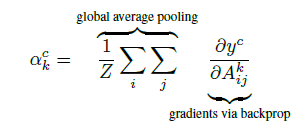

In simple words:  
Note that if the feature extractor outputs activation maps with shape [1,k,v,u] [batch size(=1), num channels, height, width] , the gradients during backpropagation for the feature extractor layer will be with the same shape.  
To calculate alpha values all we need to do is calculate the average of all dimensions except the channel dimension, so the output will have the shape [1,k,1,1] which is like [k].

Implement the function ```gradients_global_avg_polling``` below.

In [ ]:
def gradients_global_avg_polling(gradients):
  ######################
  ### YOUR CODE HERE ###
  ######################
  # return ...
  pass

In [ ]:
alpha_values = gradients_global_avg_polling(gradients)
print("Alpha values shape:", alpha_values.shape)

The shape of the result should equal to k (=512) which is the number of channels in the features from the last conv layer.

##### **3.3 Grad-CAM Heatmap**

Now that we have our alpha values, we use each alpha value as the weight of the corresponding feature map, and calculate a weighted sum of feature maps as the final Grad-CAM heatmap. The Grad-Cam for class $c$ would be:

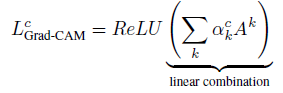

Note that we apply a ReLU operation to emphasize only the positive values and turn all the negative values into 0.

In other words, we go over each feature map (each channel) of the extracted features and multiply it by the alpha calculated in the previous step.

In [ ]:
def grad_cam_heatmap(activations, alpha_values):
  activations = activations.clone()
  ######################
  ### YOUR CODE HERE ###
  ######################
  # multiply each feature channel with its alpha value
  # ...
  ######################
  # create a heatmap by average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()
  # apply relu and normalize the heatmap
  heatmap = F.relu(heatmap)
  heatmap /= torch.max(heatmap)
  return heatmap
  

We can now calculate the heatmap and plot it.

In [ ]:
# calculate heatmap
heatmap = grad_cam_heatmap(activations, alpha_values).detach().cpu().numpy()
# print heatmap shape
print("Heatmap Shape:", heatmap.shape)
# plot heatmap
plt.matshow(heatmap.squeeze())

We would like now to apply the heatmap to the input image to see what parts of the image the network is looking for when classifying a fox.  

But, note that the shape of the heatmap is 14x14 which is much smaller than the input image.
At first glance, you may wonder how this makes sense, but it turns out it is okay if the  Grad-CAM heatmap is a lot smaller than the original input image size. All we need to do is up-sample the tiny heatmap to match the size of the original image before we make the final visualization.

This can be done using cv2:



In [ ]:
def plot_image_with_heatmap(image_path, heatmap):
  img = cv2.imread(content_image_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)

In [ ]:
plot_image_with_heatmap(content_image_path, heatmap)

You should see that the model looks at the face (eyes and nose) when classifying the image as a `red fox`.